# Bring Feature Engineering Back to Your Computer Vision Projects

> This notebook has been published as a ...  

Exploring and (then) engineering features from data is a fundamental practice in predictive modeling. However, today, more attention is placed on feature engineering in the tabular machine learning community compared to others, such as in Natural Language Processing and Computer Vision. For these tasks, machine learning practitioners more commonly trust the features extracted by neural networks to capture signal pertinent to their modeling task. 

Here, I'm going to play "devil's advocate" and see if we can beat out modern neural networks with straight feature engineering + (smaller, simpler) linear models. To do so, we'll take a deep dive into a land cover classification task with data sampled from 100,000 square miles of satellite imagery from the East Coast of the US. 

Spoiler warning: Indeed, the results of our experiments suggest that linear models trained on engineered features perform similarly to much larger deep networks trained with modern recipes for the task at hand. 

## Setup

In [1]:
# general libraries
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import copy

In [6]:
!git clone https://github.com/daniel-furman/vision-final-project.git

## Read in and check the images

In [7]:
# mapping from labels to label names

label_dict = {
    7: 'NaN',
    0: 'Water',#: All areas of open water including ponds, rivers, and lakes
    1: 'Tree Canopy and Shrubs',#: All woody vegetation including trees and shrubs
    2: 'Low Vegetation',#: Plant material less than 2 meters in height including lawns
    3: 'Barren',#: Areas devoid of vegetation consisting of natural earthen material
    4: 'Impervious Surfaces',#: Human-constructed surfaces less than 2 meters in height
    5: 'Impervious Roads',#: Impervious surfaces that are used for transportation
    6: 'Aberdeen Proving Ground',#: U.S. Army facility with no labels


}

label_dict_inv = {v: k for k, v in label_dict.items()}


# data input for training set

train_labels = []
train_images = []
 
for state in ['train_set']:

    fdir_de = glob.glob(f'/work/vision-final-project/patches_dataset/{state}/**/**/*npy')

    # Combine rgb and nir bands into ful 4-band image

    i_itr = 0
    for f in fdir_de:
        if f.split('.')[0][-3:] == 'nir':
            id_itr = f.split('_')[2].split('/')[-1]
            rgb_f = f.replace("nir", "rgb")
            nir_f = copy.deepcopy(f)
            label = label_dict_inv[f.split('/')[-3]]
            rgb = np.load(rgb_f)
            nir = np.load(nir_f)
            image = np.dstack((rgb, nir))

            train_labels.append(label)
            train_images.append(image)

            i_itr += 1



# data input for validation set (Deleware)

val_labels = []
val_images = []
 
for state in ['val_set']:

    fdir_de = glob.glob(f'/work/vision-final-project/patches_dataset/{state}/**/**/*npy')

    # Combine rgb and nir bands into ful 4-band image

    i_itr = 0
    for f in fdir_de:
        if f.split('.')[0][-3:] == 'nir':
            id_itr = f.split('_')[2].split('/')[-1]
            rgb_f = f.replace("nir", "rgb")
            nir_f = copy.deepcopy(f)
            label = label_dict_inv[f.split('/')[-3]]
            rgb = np.load(rgb_f)
            nir = np.load(nir_f)
            image = np.dstack((rgb, nir))

            val_labels.append(label)
            val_images.append(image)

            i_itr += 1


# data input for test set (Pennsylvania)

test_labels = []
test_images = []
 
for state in ['test_set']:

    fdir_de = glob.glob(f'/work/vision-final-project/patches_dataset/{state}/**/**/*npy')

    # Combine rgb and nir bands into ful 4-band image

    i_itr = 0
    for f in fdir_de:
        if f.split('.')[0][-3:] == 'nir':
            id_itr = f.split('_')[2].split('/')[-1]
            rgb_f = f.replace("nir", "rgb")
            nir_f = copy.deepcopy(f)
            label = label_dict_inv[f.split('/')[-3]]
            rgb = np.load(rgb_f)
            nir = np.load(nir_f)
            image = np.dstack((rgb, nir))

            test_labels.append(label)
            test_images.append(image)

            i_itr += 1



In [4]:
print(f'The training set has {len(train_images)} images\n   - of size {train_images[0].shape}')
print(f'The training set has {len(train_labels)} labels\n')

print(f'The validation set has {len(val_images)} images\n   - of size {val_images[0].shape}')
print(f'The validation set has {len(val_labels)} labels\n')

print(f'The test set has {len(test_images)} images\n   - of size {test_images[0].shape}')
print(f'The test set has {len(test_labels)} labels')

IndexError: list index out of range

In [10]:
# duplicated images check:

# this code fails in some notebooks due to kernel running out of RAM, 
# when run in an adequatedly sized RAM environment, the code outputs
# that there are 0 duplicates among the images (across all sets 
# considered in aggregate)

"""

flattened_images = pd.DataFrame(np.zeros((len(train_images[0].flatten()), len(train_images)+len(val_images)+len(test_images)))).T

itr = 0
for img in train_images:
    flattened_images.loc[itr] = img.flatten()
    itr += 1 

for img in val_images:
    flattened_images.loc[itr] = img.flatten()
    itr += 1 

for img in test_images:
    flattened_images.loc[itr] = img.flatten()
    itr += 1     

print(f'There are {len(flattened_images)-len(flattened_images.drop_duplicates())} duplicated images across the dataset')

"""

print(f'There are 0 duplicated images across the dataset')


There are 0 duplicated images across the dataset


The remote sensing dataset used herein was created during the 2013/2014 Chesapeake Conservancy Land Cover data project with imagery captured by the National Agriculture Imagery Program (NAIP). In full, the dataset contains 100,000 square miles
of the Chesapeake Bay watershed and represents 6 states and 206 counties (see below map for extent). The imagery is 4-band (RGB + NIR) and at 1mx1m in resolution. The Python library torchgeo facilitated the grid sampling of smaller 128 x 128 pixel patches from the raw geospatial imagery.

The 5 land use classes (see below) come originally as semantic segmentation masks. I plan to convert them into a multi-class classification problem by only selecting patches where a single label occurs over at least 85% of the area. The key assumption here is that such examples are representative of the most frequent class; based on preliminary inspection, this seems to be a
sound assumption. See x.py script for the implementation of the patch extraction. 

1. Water: All areas of open water including ponds, rivers, and lakes

2. Tree Canopy and Shrubs: All woody vegetation including trees and shrubs

3. Low Vegetation: Plant material less than 2 meters in height including lawns

4. Barren: Areas devoid of vegetation consisting of natural earthen material

5. Impervious Surfaces: Human-constructed surfaces less than 2 meters in height

## Visualize the images

### RGB (visual spectrum)

In [32]:
# plot 3 random images from the train, validation, and test sets each
# visualizes all features on the same 9 images in total

id_plot = np.random.randint(0, 2000, 3)

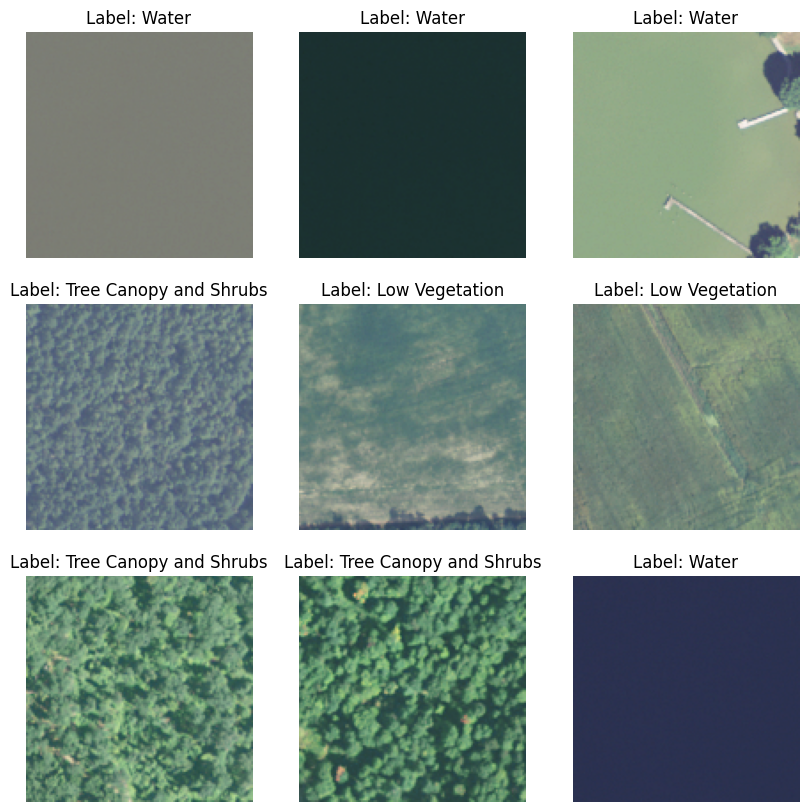

In [33]:
plt.figure(figsize=(10, 10))

i = 0
for ids in id_plot:
    sample_image, sample_label = train_images[ids][:,:,0:3].astype(np.float32), train_labels[ids] 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_image)
    plt.title(f'Label: {label_dict[sample_label]}')
    plt.axis("off")
    i+=1
# plot some random images from the val set


for ids in id_plot:
    sample_image, sample_label = val_images[ids][:,:,0:3].astype(np.float32), val_labels[ids] 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_image)
    plt.title(f'Label: {label_dict[sample_label]}')
    plt.axis("off")
    i+=1

# plot some random images in the test set


for ids in id_plot:
    sample_image, sample_label = test_images[ids][:,:,0:3].astype(np.float32), test_labels[ids] 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_image)
    plt.title(f'Label: {label_dict[sample_label]}')
    plt.axis("off")
    i+=1


### Near Infrared (NIR)

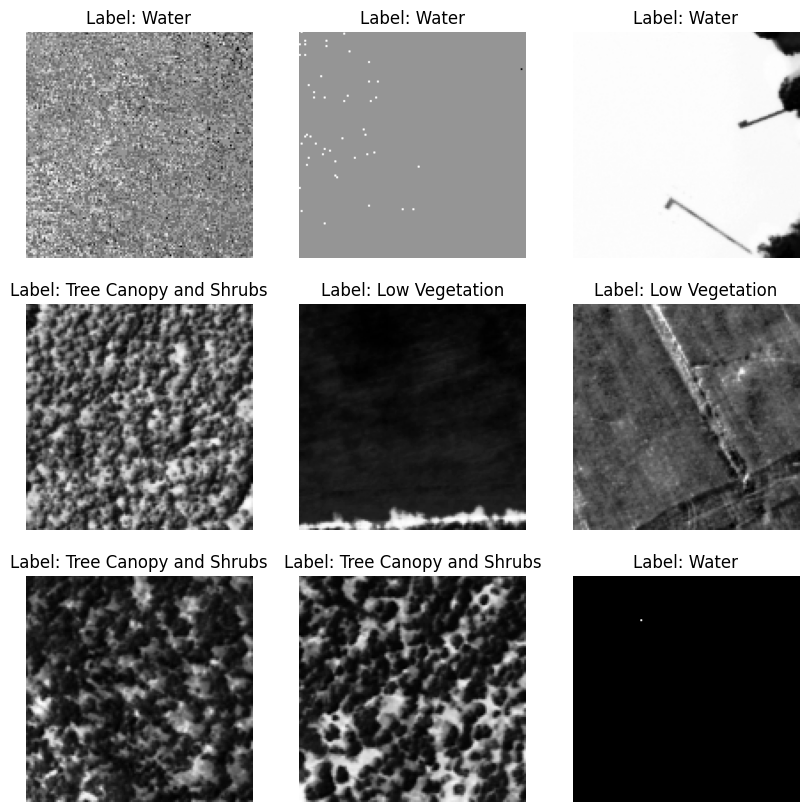

In [34]:
# plot some random images from the train set

plt.figure(figsize=(10, 10))

i = 0
for ids in id_plot:
    sample_image, sample_label = train_images[ids][:,:,3].astype(np.float32), train_labels[ids] 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_image, cmap = 'Greys')
    plt.title(f'Label: {label_dict[sample_label]}')
    plt.axis("off")
    i+=1
# plot some random images from the val set

for ids in id_plot:
    sample_image, sample_label = val_images[ids][:,:,3].astype(np.float32), val_labels[ids] 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_image, cmap = 'Greys')
    plt.title(f'Label: {label_dict[sample_label]}')
    plt.axis("off")
    i+=1

# plot some random images in the test set

for ids in id_plot:
    sample_image, sample_label = test_images[ids][:,:,3].astype(np.float32), test_labels[ids] 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(sample_image, cmap = 'Greys')
    plt.title(f'Label: {label_dict[sample_label]}')
    plt.axis("off")
    i+=1


### Edges (canny detector)

### Hog (histogram of gradients)

### PCA (qualitative cut off at n dims)

### ViT embeddings

In [ ]:
# load in npys of these features through git
# add imshow of features (edges, Hog, pca, ViTs)

# write one pipeline to do this for any given input type:
# add mean / std plots where each dot is an image
# add tsne / pca visualizations of these as pngs
# ^ read it in as a function from a script in files

In [ ]:
# in turned in version have the shallow learning experiments here

In [ ]:
# read in preds for 2 hyper-param tuned model types across these four features
# use sklearn logistic reg and ffnn

# do balanced accuracy with bootstrap and class tables (as pngs from powerpoint?)

In [ ]:
# read in preds for resnet baseline

# do balanced accuracy with bootstrap and class tables (as pngs from powerpoint?)

(to a 21 million parameter deep neural network (Resnet34) trained with the MixUp augmentation, which is a common "first pass" modeling recipe for CV competitions.)